In [318]:
import numpy as np
import numpy.matlib as ml
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.utils import resample
import seaborn as sns


In [293]:
sns.set_theme(style="darkgrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

In [294]:
import os
import FUNC_Stable3_GasSphere_ElasticShellViscFlesh as vefunc

# Fixed Parameters
Most parameters are fixed for Limacina

In [295]:
M_order=3

ro1=1027    # Surronding Water density  "kg/m³"
ro2=1040  # Surronding viscouis layer (fish flesh) density  "kg/m³"
ro3=1141  # Elastic sphere Density "kg/m³"
ro4=51.3  # Inner Gas Sphere Density "kg/m³"

c1=1462    # Surronding Water speed of sound "m/s" @ 4,3deg 31,2 PSU
c2=1523    # Surronding viscouis layer (fish flesh) speed of sound "m/s"
#c3=1480    # Elastic sphere speed of sound "m/s"
c4=325.1    # gas speed of sound "m/s"

Eta2=2*0.428572
Mu2=Eta2
Kisi2=Mu2+4*Eta2/3
    
Mu3=0.17*1.0E6  # "N/m²" shear rigidity of elastic shell
Landa3=2.4*1E9  # "N/m²" Compressional rigidity of elastic shell

c3=(ro3/(Landa3+2*Mu3))**-0.5    # Elastic sphere speed of sound "m/s"

In [296]:
# set fixed values
params_lima ={'ro1':ro1,
            'ro2':ro2,
            'ro3':ro3,
            'ro4':ro4,
            'c1':c1,
            'c2':c2,
            'c3':c3,
            'c4':c4,
            'Eta2':Eta2,
            'Mu3':Mu3,
            'Landa3':Landa3,
            'Kisi2':Kisi2}

## Variable Parameters
For these model simulations the only variable is the **SHAPE.**

The main variable parameter is R3- the radius of the swimbladder including the wall. In the case of Limacina it is the whole measured length (or calculated width).

The other two variable parameters are R4- radius of the swimbladder (R3-thickness of swimbladder wall) and R2-radius of fish fesh, since there is not flesh around the shell in a Limacina, we use R4=R3.

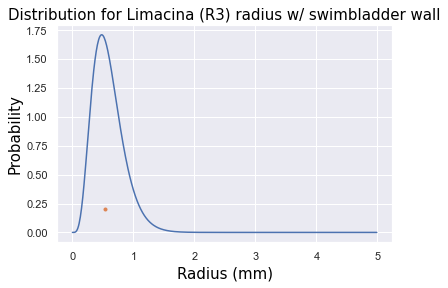

In [297]:
# Radius R3 distribution
# Values from lengthDist.Rmd. scale is 1/rate. shape is alpha. 
# radius distribution was calculated using all measured lengths (divided by 2!) and their associated widths(Divided by 2!) (L/a=1.5 Stanton 2000)
x=np.arange(0,5,0.01)
R3_dist = stats.gamma.pdf(x,a=5.4,scale=1/9.17)

plt.plot(x,R3_dist)
plt.plot(np.random.gamma(5.4,1/9.17),0.2, '.')
plt.title('Distribution for Limacina (R3) radius w/ swimbladder wall', title_font)
plt.xlabel('Radius (mm)', axis_font)
plt.ylabel('Probability', axis_font);

## Set up simulation

In [298]:
# Frequency range
min_freq=100*1000
max_freq=600*1000
frequencySpacing=500
Freq_vec=np.arange(min_freq,max_freq,frequencySpacing) 

## Run ensembles

In [299]:
nsim = 1000
nfreqs = len(Freq_vec)

# Allocate space for speed
R3_ensemble = np.zeros((nsim,1))
R4_ensemble = np.zeros((nsim,1))
TS_simulations = np.zeros((nsim*nfreqs))
freqs=np.zeros((nsim*nfreqs))

for ind_sim in np.arange(nsim):
    
    # Set new radius parameters
    R3 = np.random.gamma(5.4,1/4.6)*1e-3
    params_lima['R3'] = R3
    params_lima['R2'] = R3
    params_lima['R4'] = R3  - (R3*0.023) 
    
    # Run the v-e model
    print('Running simulations for radius %.2f mm, simulation %.0f' %(R3*1000,ind_sim))
    TS_vec_lima = vefunc.run_ve(Freq_vec, M_order, params_lima)
    
    # Save each iterated radius values
    R3_ensemble[ind_sim] = R3
    R4_ensemble[ind_sim] = params_lima['R4']

    # Save all results.
    TS_simulations[ind_sim*nfreqs:ind_sim*nfreqs+nfreqs] = TS_vec_lima
    freqs[ind_sim*nfreqs:ind_sim*nfreqs+nfreqs] = Freq_vec

Running simulations for radius 1.40 mm, simulation 0
Running simulations for radius 2.15 mm, simulation 1
Running simulations for radius 0.61 mm, simulation 2
Running simulations for radius 0.54 mm, simulation 3
Running simulations for radius 1.14 mm, simulation 4
Running simulations for radius 0.61 mm, simulation 5
Running simulations for radius 1.53 mm, simulation 6
Running simulations for radius 1.49 mm, simulation 7
Running simulations for radius 2.59 mm, simulation 8
Running simulations for radius 0.59 mm, simulation 9
Running simulations for radius 1.23 mm, simulation 10
Running simulations for radius 0.67 mm, simulation 11
Running simulations for radius 1.35 mm, simulation 12
Running simulations for radius 1.67 mm, simulation 13
Running simulations for radius 1.13 mm, simulation 14
Running simulations for radius 0.75 mm, simulation 15
Running simulations for radius 1.23 mm, simulation 16
Running simulations for radius 1.37 mm, simulation 17
Running simulations for radius 1.68 mm

Running simulations for radius 1.09 mm, simulation 151
Running simulations for radius 0.64 mm, simulation 152
Running simulations for radius 0.77 mm, simulation 153
Running simulations for radius 1.53 mm, simulation 154
Running simulations for radius 0.67 mm, simulation 155
Running simulations for radius 1.66 mm, simulation 156
Running simulations for radius 0.94 mm, simulation 157
Running simulations for radius 1.44 mm, simulation 158
Running simulations for radius 1.05 mm, simulation 159
Running simulations for radius 1.20 mm, simulation 160
Running simulations for radius 2.36 mm, simulation 161
Running simulations for radius 0.68 mm, simulation 162
Running simulations for radius 1.32 mm, simulation 163
Running simulations for radius 1.09 mm, simulation 164
Running simulations for radius 0.49 mm, simulation 165
Running simulations for radius 1.76 mm, simulation 166
Running simulations for radius 1.09 mm, simulation 167
Running simulations for radius 0.68 mm, simulation 168
Running si

Running simulations for radius 1.33 mm, simulation 300
Running simulations for radius 0.63 mm, simulation 301
Running simulations for radius 1.00 mm, simulation 302
Running simulations for radius 0.33 mm, simulation 303
Running simulations for radius 1.17 mm, simulation 304
Running simulations for radius 0.61 mm, simulation 305
Running simulations for radius 1.05 mm, simulation 306
Running simulations for radius 1.38 mm, simulation 307
Running simulations for radius 0.87 mm, simulation 308
Running simulations for radius 1.50 mm, simulation 309
Running simulations for radius 0.42 mm, simulation 310
Running simulations for radius 1.89 mm, simulation 311
Running simulations for radius 0.54 mm, simulation 312
Running simulations for radius 1.46 mm, simulation 313
Running simulations for radius 2.58 mm, simulation 314
Running simulations for radius 0.71 mm, simulation 315
Running simulations for radius 1.27 mm, simulation 316
Running simulations for radius 1.24 mm, simulation 317
Running si

Running simulations for radius 1.64 mm, simulation 449
Running simulations for radius 0.91 mm, simulation 450
Running simulations for radius 1.23 mm, simulation 451
Running simulations for radius 1.26 mm, simulation 452
Running simulations for radius 0.31 mm, simulation 453
Running simulations for radius 1.19 mm, simulation 454
Running simulations for radius 0.93 mm, simulation 455
Running simulations for radius 0.97 mm, simulation 456
Running simulations for radius 0.82 mm, simulation 457
Running simulations for radius 1.25 mm, simulation 458
Running simulations for radius 1.31 mm, simulation 459
Running simulations for radius 1.54 mm, simulation 460
Running simulations for radius 1.17 mm, simulation 461
Running simulations for radius 0.80 mm, simulation 462
Running simulations for radius 1.09 mm, simulation 463
Running simulations for radius 0.65 mm, simulation 464
Running simulations for radius 0.97 mm, simulation 465
Running simulations for radius 1.08 mm, simulation 466
Running si

Running simulations for radius 2.28 mm, simulation 598
Running simulations for radius 1.35 mm, simulation 599
Running simulations for radius 0.61 mm, simulation 600
Running simulations for radius 0.70 mm, simulation 601
Running simulations for radius 1.05 mm, simulation 602
Running simulations for radius 0.66 mm, simulation 603
Running simulations for radius 0.81 mm, simulation 604
Running simulations for radius 0.71 mm, simulation 605
Running simulations for radius 1.01 mm, simulation 606
Running simulations for radius 0.77 mm, simulation 607
Running simulations for radius 1.87 mm, simulation 608
Running simulations for radius 0.88 mm, simulation 609
Running simulations for radius 0.55 mm, simulation 610
Running simulations for radius 0.84 mm, simulation 611
Running simulations for radius 1.03 mm, simulation 612
Running simulations for radius 0.53 mm, simulation 613
Running simulations for radius 0.90 mm, simulation 614
Running simulations for radius 1.66 mm, simulation 615
Running si

Running simulations for radius 0.61 mm, simulation 747
Running simulations for radius 1.67 mm, simulation 748
Running simulations for radius 1.00 mm, simulation 749
Running simulations for radius 1.85 mm, simulation 750
Running simulations for radius 1.30 mm, simulation 751
Running simulations for radius 0.70 mm, simulation 752
Running simulations for radius 1.30 mm, simulation 753
Running simulations for radius 0.76 mm, simulation 754
Running simulations for radius 0.67 mm, simulation 755
Running simulations for radius 0.91 mm, simulation 756
Running simulations for radius 1.19 mm, simulation 757
Running simulations for radius 1.42 mm, simulation 758
Running simulations for radius 1.22 mm, simulation 759
Running simulations for radius 0.94 mm, simulation 760
Running simulations for radius 0.28 mm, simulation 761
Running simulations for radius 1.78 mm, simulation 762
Running simulations for radius 1.56 mm, simulation 763
Running simulations for radius 0.93 mm, simulation 764
Running si

Running simulations for radius 1.70 mm, simulation 896
Running simulations for radius 1.40 mm, simulation 897
Running simulations for radius 1.16 mm, simulation 898
Running simulations for radius 1.19 mm, simulation 899
Running simulations for radius 1.54 mm, simulation 900
Running simulations for radius 1.06 mm, simulation 901
Running simulations for radius 0.51 mm, simulation 902
Running simulations for radius 1.22 mm, simulation 903
Running simulations for radius 0.89 mm, simulation 904
Running simulations for radius 1.53 mm, simulation 905
Running simulations for radius 1.22 mm, simulation 906
Running simulations for radius 0.68 mm, simulation 907
Running simulations for radius 2.48 mm, simulation 908
Running simulations for radius 0.97 mm, simulation 909
Running simulations for radius 1.42 mm, simulation 910
Running simulations for radius 1.50 mm, simulation 911
Running simulations for radius 0.48 mm, simulation 912
Running simulations for radius 1.97 mm, simulation 913
Running si

In [307]:
# Repeat R3 array to match TS and freqs
R3_sims = ml.repmat(R3_ensemble,1, nfreqs)
R3_simulations = R3_sims.reshape(-1)

## Create dataframe for results

In [308]:
ve_simdata=pd.DataFrame({'freqs':freqs/1000,'TS_lima':TS_simulations, 'R3 (mm)': R3_simulations*1000})

# Plot results
Colour is used to indicated the effect of shape (Limacina radius at the angle of incidence) on the frequency response.

(100.0, 600.0)

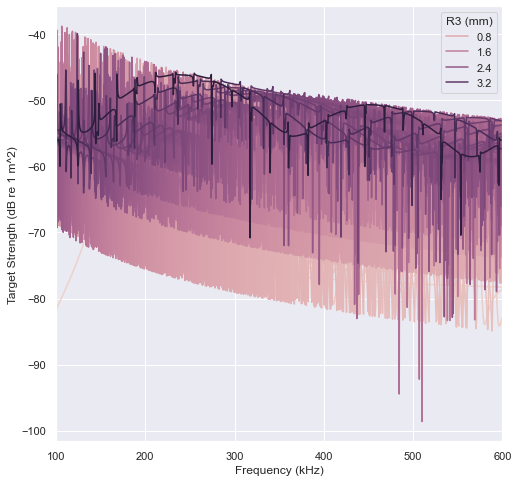

In [309]:
plt.figure(figsize=(8,8))
sns.lineplot(data=ve_simdata, x='freqs',y='TS_lima',hue='R3 (mm)')
plt.ylabel('Target Strength (dB re 1 m^2)')
plt.xlabel('Frequency (kHz)')
plt.xlim([100, 600])

(185.0, 383.0)

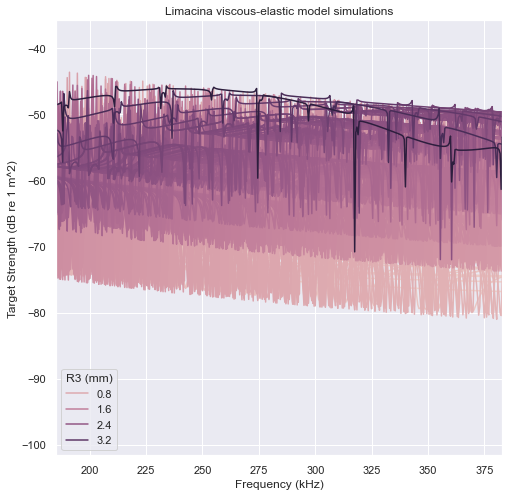

In [310]:
plt.figure(figsize=(8,8))
sns.lineplot(data=ve_simdata, x='freqs',y='TS_lima',hue='R3 (mm)')
plt.ylabel('Target Strength (dB re 1 m^2)')
plt.xlabel('Frequency (kHz)')
plt.title('Limacina viscous-elastic model simulations')
plt.xlim([185, 383])

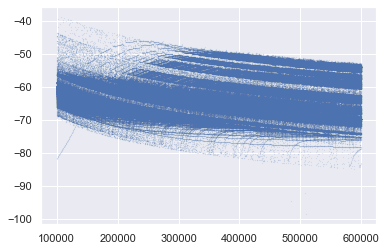

In [311]:
F_TS_MAT=np.concatenate((freqs.reshape(-1,1),TS_simulations.reshape(-1,1)),axis=1)
plt.plot(F_TS_MAT[:,0],F_TS_MAT[:,1], '.', markersize=0.1)

## Write to file
Write the results in a text file with a header of parameters and a row for each frequency and TS.

Should I add R3?

In [312]:
# uncomment when ready.
#vefunc.write_ve('./ve_results/ve_simulations_limacina.txt', M_order, params_lima, F_TS_MAT)

In [316]:
ve_simdata['sigbs'] = 10**(ve_simdata['TS_lima']/10)
mean_bs = ve_simdata.groupby(["freqs"]).agg({'sigbs':'mean'})

Text(0.5, 1.0, 'Limacina viscous-elastic model simulations')

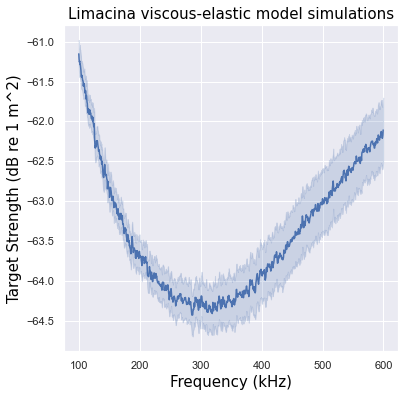

In [314]:
plt.figure(figsize=(6,5))
sns.lineplot(data=ve_simdata, x='freqs',y='TS_lima')
plt.ylabel('Target Strength (dB re 1 m^2)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Limacina', title_font)

In [319]:
simulations=ve_simdata
n_boots=100
percentiles=(2.5, 97.5)
# First, calculate mean for each frequency of the whole sample
mean_bs = simulations.groupby(['freqs']).mean()['sigbs']


# Resample , calculate mean repeat n_boot times, then calculate the SPREAD of the MEANS.
sigbs = simulations.sigbs
freq = simulations.freqs
freqs = np.unique(freq)

# Create our empty array to fill the results
ci_boot = np.zeros([2, len(freqs)])

# Resample over each frequency
for i in range(len(freqs)):
    sigbs_selectfreq = sigbs[freq==freqs[i]]

    # Create our empty array to fill the results              
    bootstrap_means = np.zeros([n_boots])

    # Resample within the values of the selected frequency and calculate the mean
    for ii in range(n_boots):
    # Generate random indices for our data *with* replacement, then take the sample mean
        random_sample = resample(sigbs_selectfreq)
        bootstrap_means[ii] = random_sample.mean(axis=0)

    # Save the percentiles of the bootstraped means for the selected frequency
    ci_boot[:,i] = np.percentile(bootstrap_means, percentiles, axis=0)

Text(0.5, 1.0, 'Limacina')

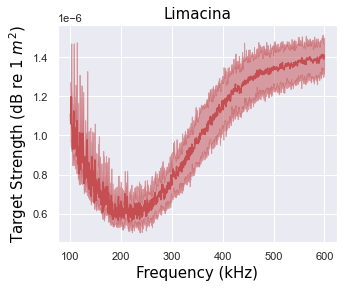

In [320]:
plt.figure(figsize=(5,4))
plt.plot(freqs, mean_bs, 'r')
plt.fill_between(freqs, ci_boot[0,:], ci_boot[1,:], alpha=0.5, color='r')
plt.ylabel('Target Strength (dB re 1 $m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Limacina', title_font)